# Introduction to Data Science - Project Phase 2
---

In [2]:
import pandas as pd
import numpy as np
import seaborn as sea
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_absolute_percentage_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback
import tensorflow as tf

from tabulate import tabulate

# Part 1: Preprocessing

A thorough preprocessing has been done in previous phase. Like filling the missing values with KNN, average of the distribution and etc.
- **Missing Data**:

    - **Dropping**: We dropped unnecessary features or features with high Null value. e.g ID, postal code

    - **K-Nearest Neighbor**: We used this algorithm for missing data of categorical features. e.g. city, baths based on the location of the house. This way we could represent the cultural feature of the city, county or the state.

    - **Filled by Distribution**: Used for some categorical features to respect the distribution. e.g. story so their number follows the distribution.

    - **Averaging Related Samples**: Used for missing data of some numerical features. e.g. latitude, sqft.

- **Some Feature Engineerings**:

    - **Feature Extraction**: New features extracted from on 'tags' feature in dataset, indicating house facilities. e.g. sport_facilities, garage

    - **Numerical Labeling**: A lot of categorical features needed relabeling to numerical values. e.g. sport_facilities, special_yard.

    - **Duplicate Labels**: Some labels in categorical features were the same in concept. So they needed to merge. e.g. 'singe_family' and 'Single-Family homes' in house_type feature.

    - **Adding New Features**: We found some related data in `tags` column and used them to create new features. Like we scored the number of views or the sport facilities or other things.

Also we removed some big outliers, exploded `tags` columns and many other stuff related to the cleaning.

# Part 2: Feature Engineering and Selection

In [3]:
data = pd.read_csv('./clean.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41674 entries, 0 to 41673
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price                    41674 non-null  float64
 1   beds                     41674 non-null  float64
 2   baths                    41674 non-null  float64
 3   garage                   41674 non-null  float64
 4   stories                  41674 non-null  int64  
 5   house_type               41674 non-null  object 
 6   sqft                     41674 non-null  float64
 7   year_built               41674 non-null  float64
 8   state                    41674 non-null  object 
 9   city                     41674 non-null  object 
 10  is_new_construction      41674 non-null  bool   
 11  sold_price               41674 non-null  float64
 12  status                   41674 non-null  object 
 13  price_reduced_amount     41674 non-null  float64
 14  county                

## Filter Datas

We chose the most frequent category in the data, hence the house price is so different due to status of the house(for sale or for rent) and, it varies greatly according to the house type. 

In [5]:
data = data[data['status'] == 'for_sale']
data = data[(data['house_type'] == 'Single-Family Homes')]


In [6]:
target = data['price']
x = data.drop(columns=['price', 'branding', 'dist', 'sold_price'], axis=1)
print(x.shape)

(26961, 34)


## Encoding

In [7]:
encoder = LabelEncoder()
for col in x.columns:
    if(x[col].dtype == 'object'):
        x[col] = encoder.fit_transform(x[col])

## Scaling

In [8]:
scaler = StandardScaler()
for col in x.columns:
    x[col] = scaler.fit_transform(x[[col]]).flatten()

## Transform Price

Due to right skewness of price distribution, we apply a natural logarithm on the price to normalize it, as you can see the distribution becomes more similar to a normal distribution,

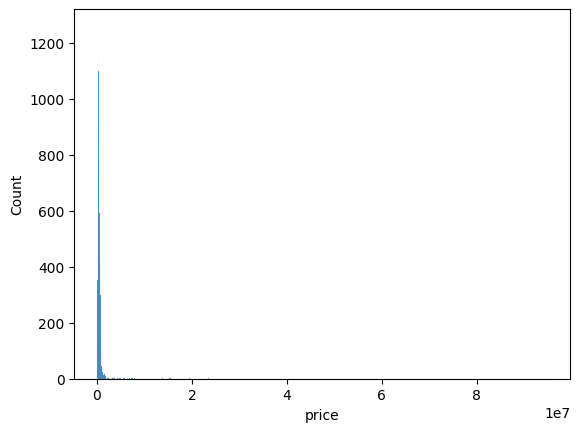

In [9]:
sea.histplot(target)
plt.show()

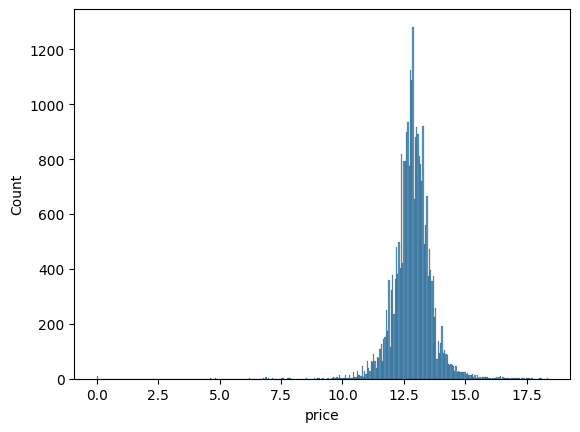

In [10]:
target_normalized = np.log(target)
sea.histplot(target_normalized)
plt.show()

## Removing Outliers

The outliers are removed by z-score, we set a 2 threshold which keeps 95 percentage of data.

In [11]:
mean = np.mean(target_normalized, axis=0)
std = np.std(target_normalized, axis=0)
z_scores = (target_normalized - mean) / std


threshold = 2
outliers = np.abs(z_scores) > threshold
target = target[~outliers]
target_normalized = target_normalized[~outliers]
x = x[~outliers]


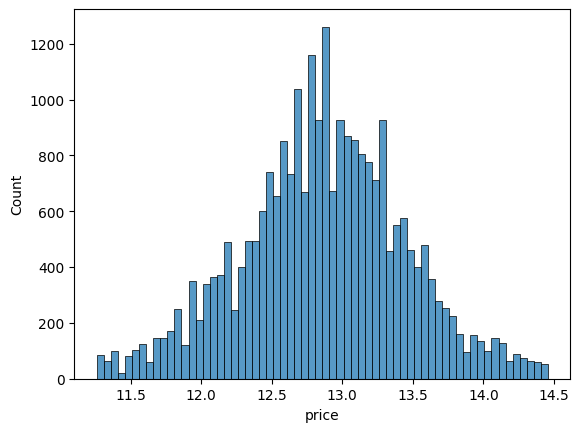

In [12]:
sea.histplot(target_normalized)
plt.show()

# Part 3: Dimensionality Reduction

In [ ]:
pca = PCA(n_components=2)
pca_2dim = pca.fit_transform(x)

pca_df = pd.DataFrame(data=pca_2dim, columns=['PC1', 'PC2'])

explained_variance = pca.explained_variance_ratio_

loadings = pca.components_

plt.figure(figsize=(8, 6))

plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7, c='b', edgecolors='k', s=50, label='Data Points')

for i in np.argsort(np.sqrt(np.sum(loadings**2, axis=0)))[-5:]:
    plt.arrow(0, 0, loadings[0, i]*max(pca_df['PC1']), loadings[1, i]*max(pca_df['PC2']),
              color='r', alpha=0.5, head_width=0.5, head_length=0.8)
    plt.text(loadings[0, i]*max(pca_df['PC1'])*1.1, loadings[1, i]*max(pca_df['PC2'])*1.1,
             data.columns[i], color='r', ha='center', va='center')

plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}% Variance)', fontsize=12)
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}% Variance)', fontsize=12)
plt.title('PCA Plot with Top 5 Feature Contributions', fontsize=15)
plt.legend()
plt.grid(True)
plt.show()

In [17]:
pca = PCA(n_components=2)
pca_2dim = pca.fit_transform(x)

explained_variance = pca.explained_variance_ratio_
total_explained_variance = np.sum(explained_variance)
print(f"total explained variance: {total_explained_variance * 100 :.2f}%")

total explained variance: 20.22%


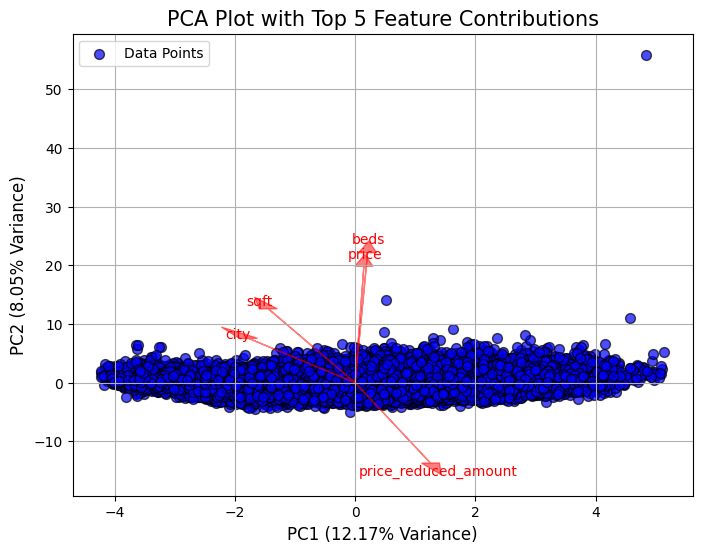

In [20]:
pca_df = pd.DataFrame(data=pca_2dim, columns=['PC1', 'PC2'])

loadings = pca.components_

plt.figure(figsize=(8, 6))

plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7, c='b', edgecolors='k', s=50, label='Data Points')

for i in np.argsort(np.sqrt(np.sum(loadings**2, axis=0)))[-5:]:
    plt.arrow(0, 0, loadings[0, i]*max(pca_df['PC1']), loadings[1, i]*max(pca_df['PC2']),
              color='r', alpha=0.5, head_width=0.3, head_length=2)
    plt.text(loadings[0, i]*max(pca_df['PC1'])*1.1, loadings[1, i]*max(pca_df['PC2'])*1.1,
             data.columns[i], color='r', ha='center', va='center')

plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}% Variance)', fontsize=12)
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}% Variance)', fontsize=12)
plt.title('PCA Plot with Top 5 Feature Contributions', fontsize=15)
plt.legend()
plt.grid(True)
plt.show()

In [21]:
pca = PCA(n_components=0.95, svd_solver='full') 
xpca = pca.fit_transform(x)
xpca.shape

print("number of reduced dimension with keeping 95% of data:", x.shape[1] - xpca.shape[1])

number of reduced dimension with keeping 95% of data: 6


# Part 4: Evaluation Metric

- **R² (R-Squared)**
R-squared is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.
$$
R^2 = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}
$$
- **MSE (Mean Squared Error)**
Mean Squared Error measures the average of the squares of the errors—that is, the average squared difference between the estimated values and the actual value.
$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2
$$

- **MAE (Mean Absolute Error)**
Mean Absolute Error measures the average magnitude of the errors in a set of predictions, without considering their direction. It's the average over the test sample of the absolute differences between prediction and actual observation.
$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^n |y_i - \hat{y}_i|
$$

- **MDE (Median Absolute Error)**
Median Absolute Error is a robust metric that is less sensitive to outliers than the mean absolute error. It is the median of the absolute differences between the predicted values and the actual values.
$$
\text{MDE} = \text{median}(|y_1 - \hat{y}_1|, |y_2 - \hat{y}_2|, \ldots, |y_n - \hat{y}_n|)
$$

- **MAPE (Mean Absolute Percentage Error)**
Mean Absolute Percentage Error measures the accuracy of a forecast system. It expresses accuracy as a percentage and is calculated as the average of the absolute percentage errors of the predicted values.
$$
\text{MAPE} = \frac{100\%}{n} \sum_{i=1}^n \left| \frac{y_i - \hat{y}_i}{y_i} \right|
$$

# Part 5: Model Training

The most importatn metric in our provlem is mean absolute error. It will give a good insight about our predictions. Also mean absolute percentage error, evaluate our model according to the range of prices.

## Method One: Neural Network

- Batch Size: 64
- Learning Rate: 5e-4
- Epochs: 15

**Architecture**:

In [869]:
train_r2 = []
test_r2 = []
def training_metrics(history):

	epochs = range(1, len(history.history['loss']) + 1)

	plt.figure(figsize=(12, 6))
	plt.subplot(1, 2, 1)
	plt.plot(epochs, history.history['loss'], 'r-', label='Training Loss')
	plt.plot(epochs, history.history['val_loss'], 'b-', label='Validation Loss')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.legend()

	plt.subplot(1, 2, 2)
	plt.plot(epochs, train_r2, 'r-', label='Training R2')
	plt.plot(epochs, test_r2, 'b-', label='Validation R2')
	plt.xlabel('Epochs')
	plt.ylabel('Accuracy')
	plt.legend()


	plt.tight_layout()
	plt.show()


In [870]:
xtrain, xtest, ytrain, ytest = train_test_split(x, target, test_size=0.1, random_state=999)

class R2Callback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(xtrain)
        r2 = r2_score(ytrain, y_pred)
        train_r2.append(r2)
        print(f" - train_r2: {r2:.4f}")
        
        y_pred = self.model.predict(xtest)
        r2 = r2_score(ytest, y_pred)
        test_r2.append(r2)
        print(f" - val_r2: {r2:.4f}")

In [871]:
model = Sequential()
model.add(Dense(128, input_dim=xtrain.shape[1], activation='relu'))
model.add(Dense(128, activation='linear'))
model.add(Dense(128, activation='tanh'))
model.add(Dense(64, activation='linear'))
model.add(Dense(64, activation='linear'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

In [835]:
model.compile(
    optimizer = tf.optimizers.Adam(learning_rate=5e-4), 
    loss='mean_absolute_error'
)


Epoch 1/10
726/726 [==============================] - 1s 2ms/step
 - train_r2: -1.4497
81/81 [==============================] - 0s 2ms/step
 - val_r2: -1.5388
363/363 [==============================] - 5s 12ms/step - loss: 433742.2188 - val_loss: 344439.1250
Epoch 2/10
726/726 [==============================] - 1s 2ms/step
 - train_r2: -0.0609
81/81 [==============================] - 0s 2ms/step
 - val_r2: -0.0649
363/363 [==============================] - 4s 11ms/step - loss: 224190.4531 - val_loss: 194103.1562
Epoch 3/10
726/726 [==============================] - 1s 2ms/step
 - train_r2: 0.4035
81/81 [==============================] - 0s 2ms/step
 - val_r2: 0.4275
363/363 [==============================] - 4s 11ms/step - loss: 155492.7969 - val_loss: 133929.5000
Epoch 4/10
726/726 [==============================] - 1s 2ms/step
 - train_r2: 0.4702
81/81 [==============================] - 0s 2ms/step
 - val_r2: 0.4916
363/363 [==============================] - 4s 11ms/step - loss: 1319

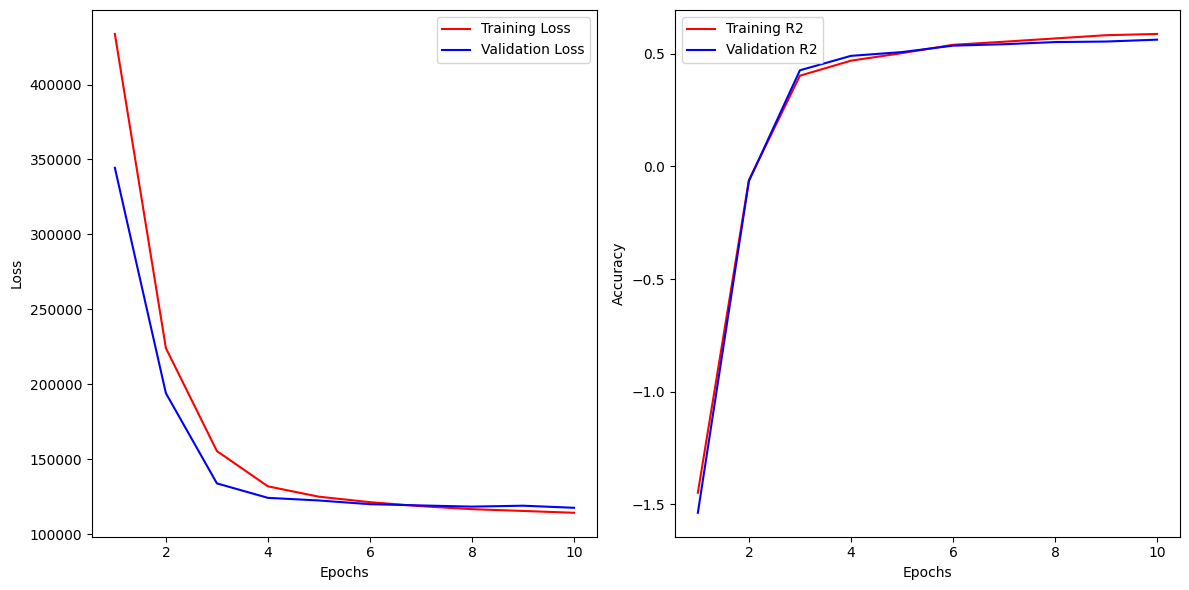

In [836]:
train_r2.clear()
test_r2.clear()
history = model.fit(
    xtrain, 
    ytrain, 
    epochs=10, 
    batch_size=64, 
    validation_data=(xtest, ytest), 
    verbose=1, 
    callbacks=[R2Callback()]
)
training_metrics(history)

## Method Two: Classic ML

In [784]:
xtrain, xtest, ytrain, ytest = train_test_split(x, target_normalized, test_size=0.1, random_state=999)

In [785]:
regressors = {
    'Decision Tree': DecisionTreeRegressor(),
    'Gradiant Boosting': GradientBoostingRegressor(),
    'Linear Regression': LinearRegression(),
	'Random Forest': RandomForestRegressor(),
	'KNN': KNeighborsRegressor(n_neighbors=21),
    'XGBoost': XGBRegressor(),
    'SVM': SVR(kernel='rbf')
}

results = []

for name, clf in regressors.items():
	clf.fit(xtrain, ytrain)
	y_pred = clf.predict(xtest)
	r2 = r2_score(ytest, y_pred)
	mse = mean_squared_error(ytest, y_pred)
	mae = mean_absolute_error(np.e ** ytest, np.e ** y_pred)
	mape = mean_absolute_percentage_error(np.e ** ytest, np.e ** y_pred)
	mde = median_absolute_error(np.e ** ytest, np.e ** y_pred)
	results.append([name, r2, mse, mae, mde, mape])
print(tabulate(results, headers=["Classifier", "R2", "MSE", "MAE", "MDE", "MAPE"], tablefmt="grid"))


+-------------------+----------+-----------+----------+---------+----------+
| Classifier        |       R2 |       MSE |      MAE |     MDE |     MAPE |
+===================+==========+===========+==========+=========+==========+
| Decision Tree     | 0.344763 | 0.213356  | 154547   | 91204   | 0.373335 |
+-------------------+----------+-----------+----------+---------+----------+
| Gradiant Boosting | 0.667914 | 0.108133  | 111269   | 70258.1 | 0.260097 |
+-------------------+----------+-----------+----------+---------+----------+
| Linear Regression | 0.438021 | 0.18299   | 160687   | 94840   | 0.383464 |
+-------------------+----------+-----------+----------+---------+----------+
| Random Forest     | 0.693595 | 0.0997707 | 103655   | 62697.1 | 0.241915 |
+-------------------+----------+-----------+----------+---------+----------+
| KNN               | 0.488295 | 0.16662   | 139864   | 85848.3 | 0.305931 |
+-------------------+----------+-----------+----------+---------+----------+

There are several potential reasons why an XGBoost model might outperform a neural network in a regression task. Here are some key factors to consider:

**1. Data Size and Quality:**
- XGBoost: Generally performs well on smaller to moderately-sized datasets because it is less prone to overfitting due to its ensemble nature.
- Neural Networks: Require large amounts of data to generalize well and prevent overfitting. If your dataset is not large enough, the neural network might struggle to learn effectively.

**2. Feature Engineering:**

- XGBoost: Can handle raw features better and automatically manage interactions between features. It also has built-in mechanisms to handle missing values and feature scaling.
- Neural Networks: Often require careful feature engineering, normalization, and handling of missing values to perform well.

**3. Hyperparameter Tuning:**
- XGBoost: Often more straightforward to tune with well-established default parameters that work well in many cases.
- Neural Networks: Require extensive tuning of various hyperparameters such as learning rate, number of layers, number of neurons per layer, activation functions, and dropout rates, which can be more complex and time-consuming.

**4. Model Complexity and Interpretability:**
- XGBoost: Tends to be less complex and more interpretable due to its decision tree-based structure. Feature importance and model behavior can be easily understood.
- Neural Networks: Often act as "black boxes," making them harder to interpret and understand. The complexity of the model architecture can also lead to overfitting if not managed properly.

# Part 6: Feature Analysis

In [840]:
results = []
xtrain, xtest, ytrain, ytest = train_test_split(xpca, target_normalized, test_size=0.1, random_state=999)

clf = XGBRegressor()
clf.fit(xtrain, ytrain)
y_pred = clf.predict(xtest)
r2 = r2_score(ytest, y_pred)
mse = mean_squared_error(ytest, y_pred)
mae = mean_absolute_error(np.e ** ytest, np.e ** y_pred)
mape = mean_absolute_percentage_error(np.e ** ytest, np.e ** y_pred)
mde = median_absolute_error(np.e ** ytest, np.e ** y_pred)
results.append(["XGBoost", r2, mse, mae, mde, mape])
print(tabulate(results, headers=["Classifier", "R2", "MSE", "MAE", "MDE", "MAPE"], tablefmt="grid"))


+--------------+---------+----------+--------+---------+----------+
| Classifier   |      R2 |      MSE |    MAE |     MDE |     MAPE |
+==============+=========+==========+========+=========+==========+
| XGBoost      | 0.52483 | 0.154723 | 136329 | 88403.5 | 0.316529 |
+--------------+---------+----------+--------+---------+----------+


1. **Loss of Important Information:** Dimensionality reduction techniques, such as PCA (Principal Component Analysis) or feature selection methods, aim to reduce the number of features by retaining only the most important information. However, they might discard some critical features that were contributing significantly to the model's predictive power.
Impact: This can lead to a reduction in the model's ability to capture the underlying patterns in the data, hence the decrease in R².


2. **Variance and Bias Tradeoff:** Dimensionality reduction often affects the bias-variance tradeoff. By reducing dimensions, you might reduce variance (lower overfitting) but increase bias (higher underfitting).

3. **Quality of Dimension Reduction:** The method and quality of dimension reduction itself play a significant role. For example, PCA transforms features into principal components that maximize variance, but these components might not always be the most predictive for the specific target variable.

This can lead to a reduction in the model's ability to capture the underlying patterns in the data, hence the decrease in R².

# Part 7: Overall Report and Discussions


## 1. Data Retrieval

We started by gathering housing data through the `Realtor.com` API. During this phase, we encountered several challenges:

- **Rate Limitations**: The API's rate limit restricted the number of requests we could make. To overcome this, we utilized multiple systems and IP addresses to distribute the load.
- **Duplicated Data**: Initially, our method for sorting and receiving data led to significant duplication. We refined our approach by implementing better sorting mechanisms to ensure the retrieval of unique listings.

After addressing these issues, we successfully collected 43,000 unique housing records, each with 25 features.

## 2. Data Cleaning

The data cleaning process was meticulous, focusing on handling missing values contextually for each column:

- **Location-based Imputation**: For certain features, we employed K-Nearest Neighbors (KNN) to impute missing values based on data from neighboring cities.
- **Statistical Methods**: For other columns, we used the average or median of the data's distribution, ensuring the imputed values were appropriate for their context.
- **Tags**: We used the data in tags column to fill some of our columns.

## 3. Feature Engineering

We enhanced the dataset by performing feature engineering:

- **Exploding Tags Columns**: Some columns contained lists of tags or categories. We exploded these columns, using One-Hot encoding so that they better represented the data's structure. We also added new columns based on that tags. 

## 4. Dimensionality Reduction

To understand the data's variance and simplify our model, we applied Principal Component Analysis (PCA):

- **Variance Explained**: We assessed how much variance was captured by the first two principal components.
- **Feature Requirement**: We determined the number of principal components needed to cover 95% of the dataset's variance.

## 5. Model Training and Evaluation

We explored several machine learning models to predict house prices:

- **Neural Networks**: Deep learning models were trained to capture complex patterns in the data.
- **Decision Tree**
- **Gradient Boosting**
- **Linear Regression**
- **Random Forest**
- **K-Nearest Neighbors (KNN)**
- **XGBoost**
- **Support Vector Machine (SVM)**

Each model was evaluated for its performance in predicting house prices, and we compared their effectiveness in terms of accuracy, precision, and computational efficiency.



# Group Members

* Matin Bazrafshan - 810100093
* Mohammad Reza Nemati - 810100226
* Parva Sharifi - 810100171
* Mohammad Farrahi - 810198451

